In [1]:
import asimov_database as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

pr = ad.ParquetReader()

In [2]:
from asimov_strategy.managers.manager import Manager
manager = Manager()


[ Asynch ] STARTING THREAD. _run


In [3]:
def qntd_seacher(test, all_trades_qnt, number):
    dict_aux_ = {}
    j= 0
    for i in range(len(all_trades_qnt)):
        if test == 'equal': 
            if all_trades_qnt[i]['qntd'] == number:
                dict_aux_[j] = all_trades_qnt[i]
                j+=1
        else:
            if all_trades_qnt[i]['qntd'] >= number:
                dict_aux_[j] = all_trades_qnt[i]
                j+=1
    return dict_aux_

In [35]:
#monte_carlo(date = '2020-01-07' , files =dict_aux_)

def monte_carlo(date, files, symbol):

    fig, ax = plt.subplots()
    last_value = []
    size = []


    for i in range(100):
        tds = fetch_with_fillrate(0.3,0.3,1, date, 'Taker', files,{'signal' : 'insert_wo_trades'})
        #manager.trades_return(tds, adtv=800, hft=False)[symbol].plot(ax=ax, alpha=0.3)  # Aplica os custos operacionais em um dos caminhos que tu criar
        last_value.append(manager.trades_return(tds, adtv=300, hft=False)[symbol][-1])# Aplica os custos operacionais em um dos caminhos que tu criar
        size.append(len(tds))# Aplica os custos operacionais em um dos caminhos que tu criar
        
    return last_value, size

In [5]:
def fetch_with_fillrate(fillrate_w, fillrate_wo, max_position, date, name,  parameter, strategy_blueprint={}, start=None, end=None, rerun=False):
        if strategy_blueprint['signal'] == 'insert':
            strategy_blueprint['signal'] = 'insert_w_trades'
            trades_w = manager._get_all_possible_trades(date, name, strategy_blueprint=strategy_blueprint, rerun=rerun)
            trades_w = pd.DataFrame(trades_w)
            trades_w['wwo'] = 0

            strategy_blueprint['signal'] = 'insert_wo_trades'
            trades_wo = manager._get_all_possible_trades(date, name, strategy_blueprint=strategy_blueprint, rerun=rerun)
            trades_wo = pd.DataFrame(trades_wo)
            trades_wo['wwo'] = 1

            trades = pd.concat([trades_w, trades_wo], sort=False)
            trades.sort_values(by=['react_msg_seq_num'], kind="mergesort", inplace=True)
            trades = trades.to_dict('records')
        else:
            trades = parameter

        if not start is None: trades = [td for td in trades if td['react_msg_seq_num'] >= start]
        if not end is None: trades = [td for td in trades if td['react_msg_seq_num'] <= end]
        
        if strategy_blueprint['signal'] == 'insert_w_trades':
            fillrate = fillrate_w
        elif strategy_blueprint['signal'] == 'insert_wo_trades':
            fillrate = fillrate_wo

        position = 0
        tds = []
        i = 0
        ts = 0
        while i < len(trades):
            msg_seq_num = trades[i]['react_msg_seq_num']
            timestamp = trades[i]['react_msg_seq_num']

            if strategy_blueprint['signal'] == 'insert':
                if trades[i]['wwo'] == 0:
                    fillrate = fillrate_w
                elif trades[i]['wwo'] == 1:
                    fillrate = fillrate_wo

            fill_trade = manager._fill_trade(fillrate) and trades[i]['timestamp'] - ts > 0.5
            ts = trades[i]['timestamp']
            side = trades[i]['side']
            while trades[i]['react_msg_seq_num'] == msg_seq_num:
                if fill_trade and max_position - position * ((side * -2) + 1) > 0:
                    quantity = min(max_position - position * ((side * -2) + 1), trades[i]['quantity'])
                    tds += [trades[i]]
                    tds[-1]['quantity'] = quantity
                    position += quantity * ((side * -2) + 1)
                i += 1
                if i == len(trades):
                    break
        return tds

In [6]:
def get_trades(dol, wdo, date_):
    trades = pr.get_parquet(symbol=dol,
                                date=date_,
                                type_='trades')
    md_trades = trades.read().to_pandas()
    trades_wdo = pr.get_parquet(symbol=wdo,
                                date=date_,
                                type_='trades')
    md_trades_wdo = trades_wdo.read().to_pandas()
    return md_trades, md_trades_wdo 


In [7]:
DATE_JAN = [
 '2020-01-02',
 '2020-01-03',
 '2020-01-06',
 '2020-01-07',
 '2020-01-08',
 '2020-01-09', 
 '2020-01-10',
 '2020-01-13',
 '2020-01-14',
 '2020-01-15',
 '2020-01-16',
 '2020-01-17',
 '2020-01-20',
 '2020-01-21',
 '2020-01-22',
 '2020-01-23',
 '2020-01-24',
 '2020-01-27']

In [5]:
DATE_DEZ = ['2019-12-02',
 '2019-12-03',
 '2019-12-04',
 '2019-12-05',
 '2019-12-06',
 '2019-12-09',
 '2019-12-10',
 '2019-12-11',
 '2019-12-12',
 '2019-12-13',
 '2019-12-16',
 '2019-12-17',
 '2019-12-18',
 '2019-12-19',
 '2019-12-20',
 '2019-12-23',
 '2019-12-26',
 '2019-12-27', 
 '2019-12-30']

/home/asimovws/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/asimovws/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


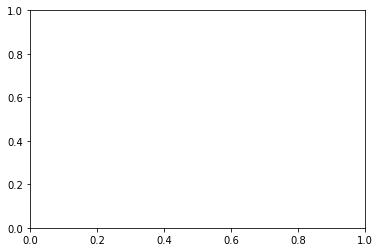

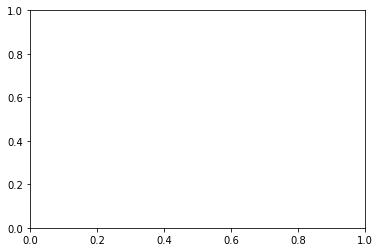

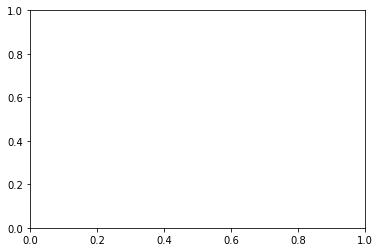

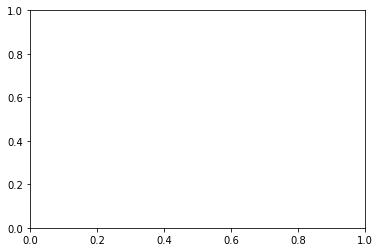

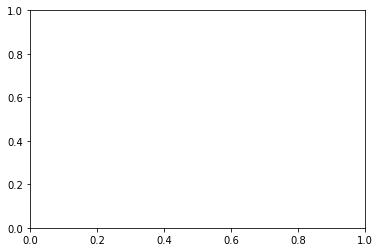

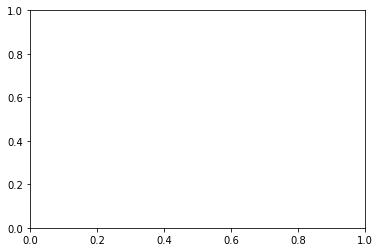

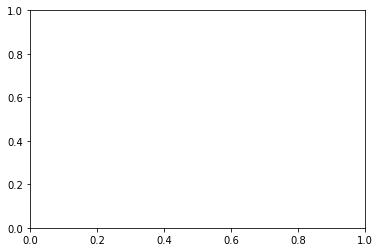

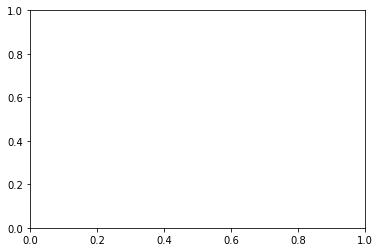

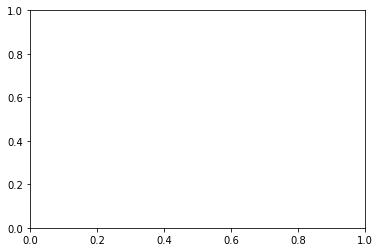

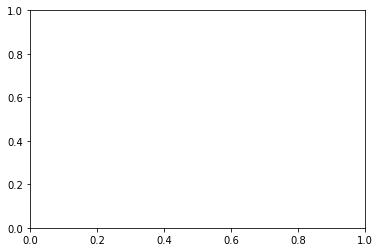

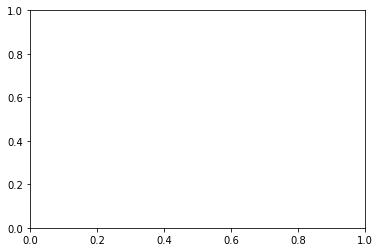

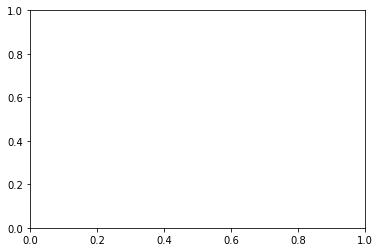

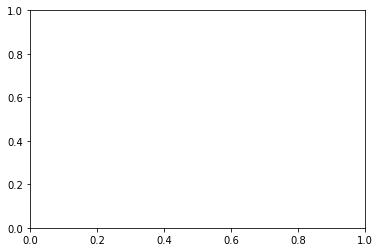

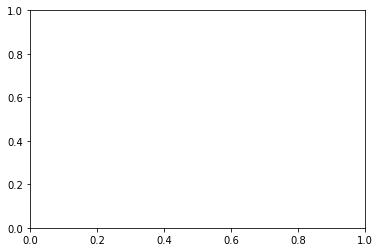

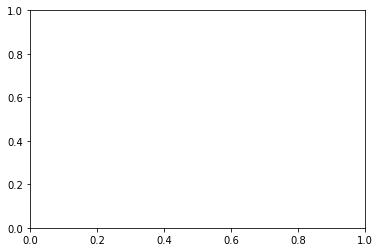

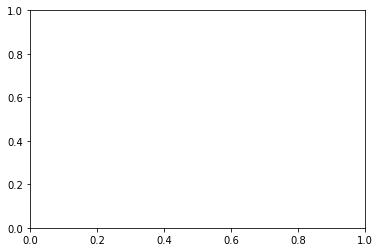

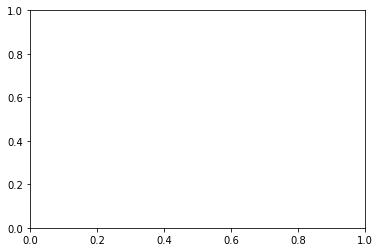

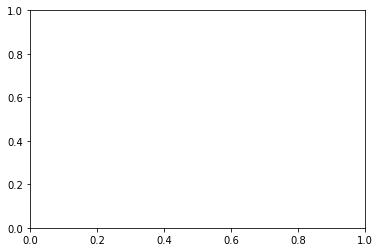

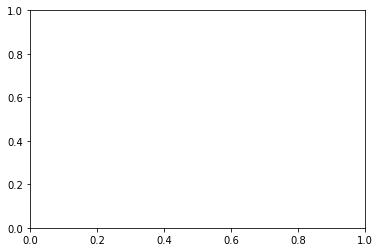

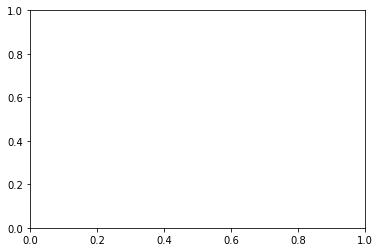

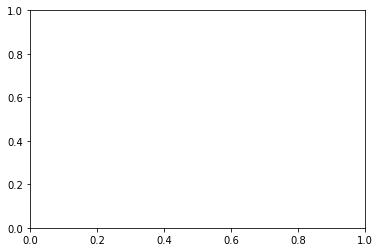

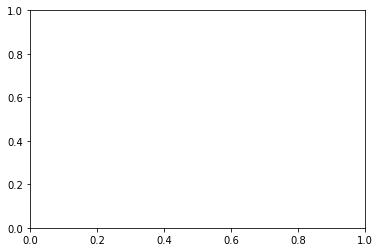

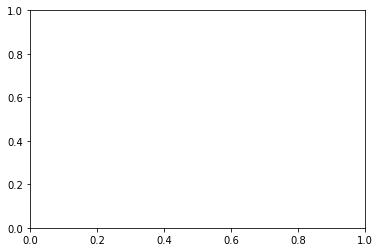

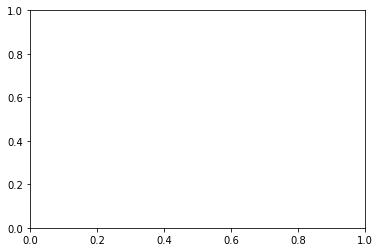

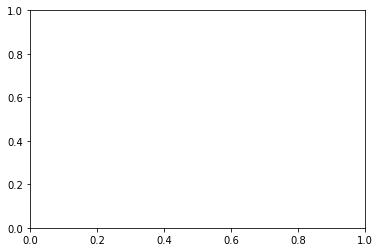

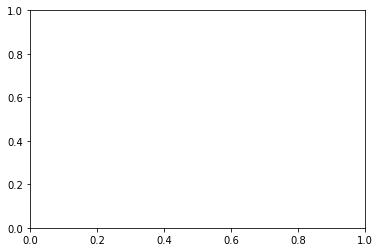

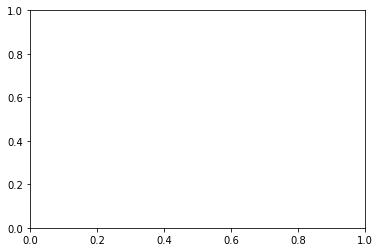

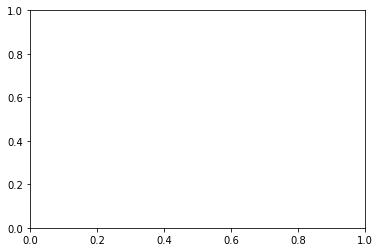

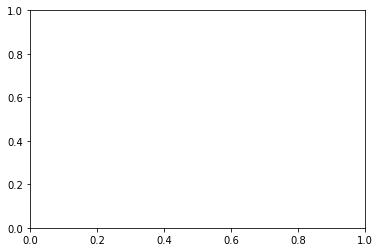

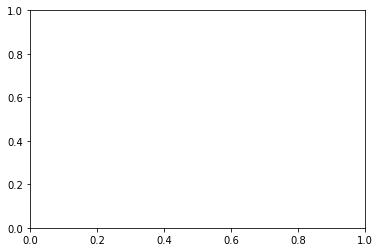

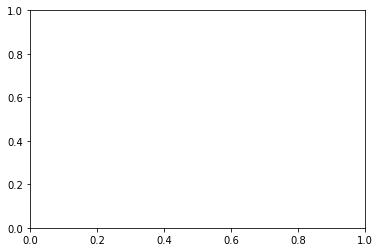

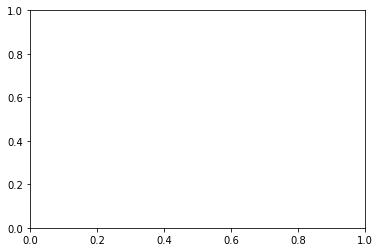

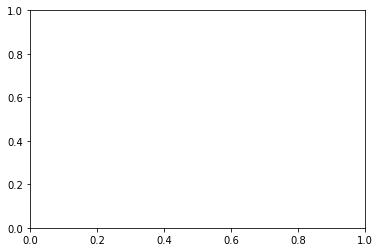

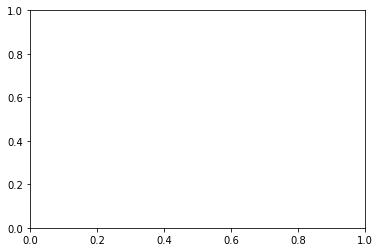

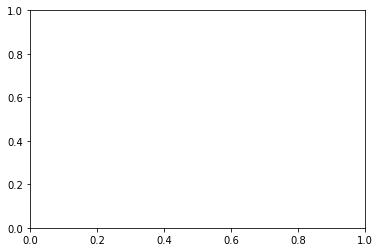

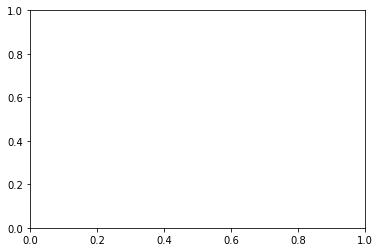

In [36]:
dict_distribution_jan = {}
dict_distribution_size_jan = {}

# dict_distribution_jan = {}
# dict_distribution_size_jan = {}

j= 0
DOL = 'DOLG20'
WDO = 'WDOG20'


for date_ in DATE_JAN:
#     e = Causality("DOLG20", "WDOG20", date_)
    events = pr.get_parquet(DOL, date_, "events")["incremental"].read().to_pandas()
    events.reset_index(inplace=True)

#     df = e._files()
    events['msg_seq_num'].duplicated().any() 
    events['repeat'] = False
    events['repeat'][events['msg_seq_num'] != events['msg_seq_num'].shift(-1)] = True
    events  = events[events['repeat']]
    insert_dol = events[events['event_type'] == 'INSERT']

    md_trades, md_trades_wdo = get_trades(DOL, WDO, date_)
    all_trades =  pd.concat([md_trades,md_trades_wdo]).sort_values(by='msg_seq_num', kind = 'mergesort').reset_index()
    list_of_trades = all_trades.groupby('msg_seq_num').sum().index
    insert_dol = insert_dol[~insert_dol['msg_seq_num'].isin(list_of_trades)].reset_index()


    all_trades_monte_carlo = manager._get_all_possible_trades(date_, 'Taker', {'signal' : 'insert_wo_trades'})  

    dict_map_qtd = insert_dol.set_index("msg_seq_num").to_dict()["quantity"]
    df_all_trades = pd.DataFrame(all_trades_monte_carlo)
    df_all_trades["qntd"] = df_all_trades["react_msg_seq_num"].map(dict_map_qtd)

    dict_aux = df_all_trades.T.to_dict()

    all_trades_qnt = []
    for i in dict_aux.keys():
        all_trades_qnt.append(dict_aux[i])


    files = qntd_seacher(test= 'equal', all_trades_qnt = all_trades_qnt , number = 5)
    equals5, equals5_size = monte_carlo(date = date_ , files =files, symbol = WDO)
    files = qntd_seacher(test= 'bigger', all_trades_qnt = all_trades_qnt , number = 6)
    bigger5, bigger5_size = monte_carlo(date = date_ , files =files, symbol = WDO)
    
    dict_distribution_jan[j] = pd.DataFrame([equals5, bigger5])
    dict_distribution_size_jan[j] = pd.DataFrame([equals5_size, bigger5_size])

#     dict_distribution_jan[j] = pd.DataFrame([equals5, bigger5])
#     dict_distribution_size_jan[j] = pd.DataFrame([equals5_size, bigger5_size])
    
    j+=1

In [ ]:
from scipy import stats
from scipy.stats import ks_2samp

In [ ]:
# # Filtra as distribuiçõe equivalentes

# dict_stats = {}
# for i in dict_distribution_jan.keys():
#     if ks_2samp(dict_distribution_jan[i].values[0],dict_distribution_jan[i].values[1])[1] < 0.05:
#         dict_stats[i] = ks_2samp(dict_distribution_jan[i].values[0],dict_distribution_jan[i].values[1])

In [37]:
Mean5 = []
Mean_b_5 = []
for j in dict_distribution_jan.keys():
    Mean5.append(np.mean(dict_distribution_jan[j].values[0]))
    Mean_b_5.append(np.mean(dict_distribution_jan[j].values[1]))


In [38]:
Mean5_size = []
Mean_b_5_size = []
for j in dict_distribution_size_jan.keys():
    Mean5_size.append(np.mean(dict_distribution_size_jan[j].values[0]))
    Mean_b_5_size.append(np.mean(dict_distribution_size_jan[j].values[1]))

In [51]:
DATE = []
for i in range(len(DATE_JAN)):
    DATE.append(DATE_JAN[i].split('-')[2])

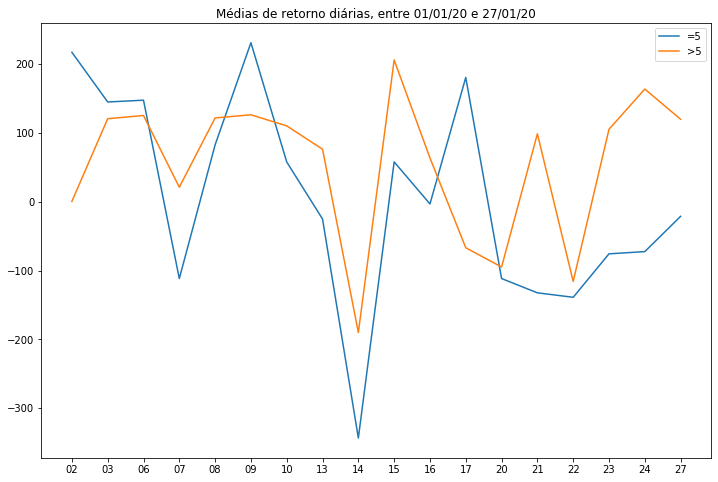

In [52]:
fig, ax = plt.subplots(figsize=(12,8))

plt.plot(DATE, Mean5,  label = '=5')
plt.plot( Mean_b_5,label = '>5')

ax.set_title('Médias de retorno diárias, entre 01/01/20 e 27/01/20')


ax.legend()

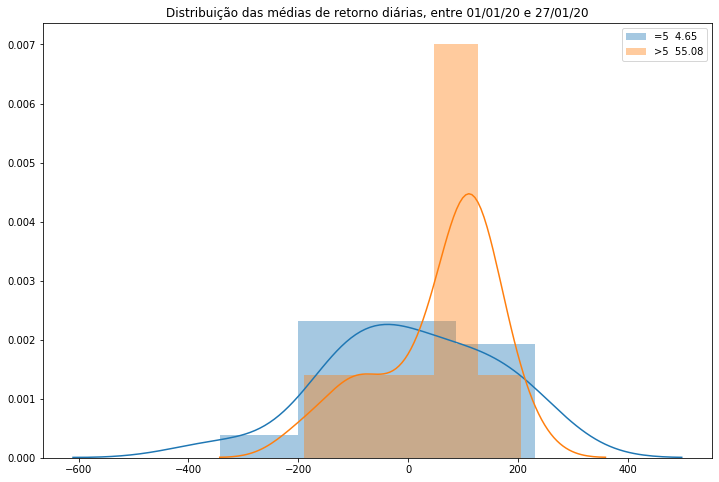

In [39]:
fig, ax = plt.subplots(figsize=(12,8))

sns.distplot(Mean5, label = '=5  {:.2f}'.format(np.mean(Mean5)))
sns.distplot(Mean_b_5, label = '>5  {:.2f}' .format(np.mean(Mean_b_5)))


ax.set_title('Distribuição das médias de retorno diárias, entre 01/01/20 e 27/01/20')
# sns.distplot(C_, label = 'All')
ax.legend()

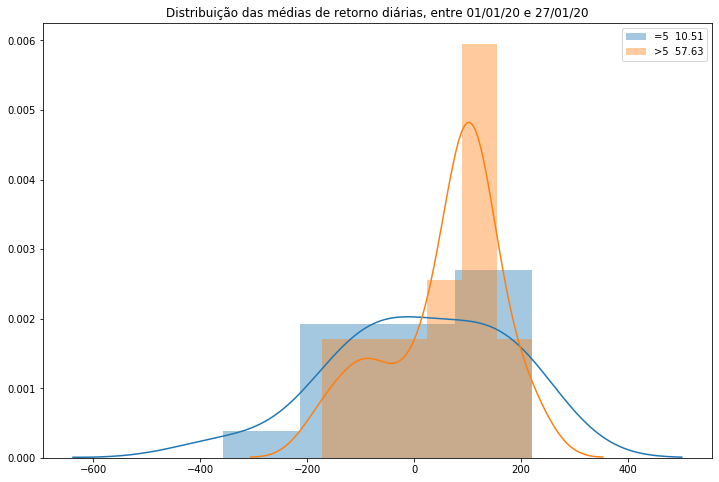

In [34]:
fig, ax = plt.subplots(figsize=(12,8))

sns.distplot(Mean5, label = '=5  {:.2f}'.format(np.mean(Mean5)))
sns.distplot(Mean_b_5, label = '>5  {:.2f}' .format(np.mean(Mean_b_5)))


ax.set_title('Distribuição das médias de retorno diárias, entre 01/01/20 e 27/01/20')
# sns.distplot(C_, label = 'All')
ax.legend()

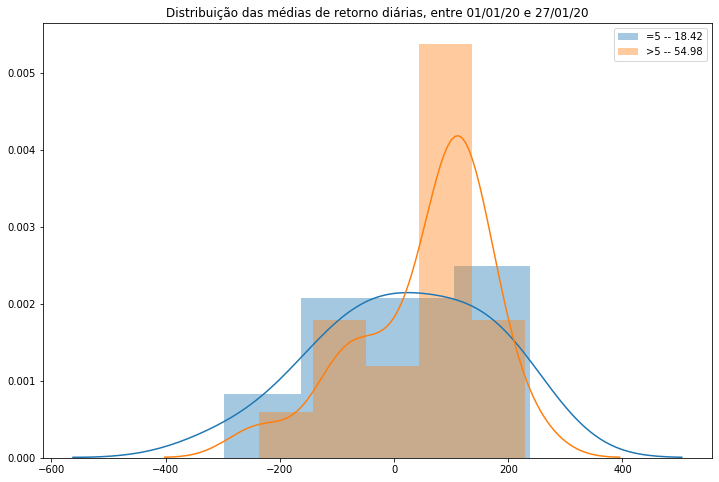

In [24]:
fig, ax = plt.subplots(figsize=(12,8))

sns.distplot(Mean5, label = '=5 -- {:.2f}'.format(np.mean(Mean5)))
sns.distplot(Mean_b_5, label = '>5 -- {:.2f}' .format(np.mean(Mean_b_5)))


ax.set_title('Distribuição das médias de retorno diárias, entre 01/01/20 e 27/01/20')
# sns.distplot(C_, label = 'All')
ax.legend()

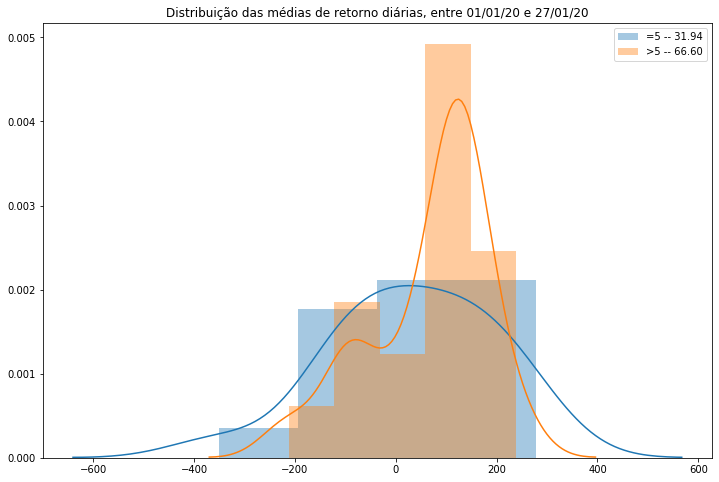

In [16]:
fig, ax = plt.subplots(figsize=(12,8))

sns.distplot(Mean5, label = '=5 -- {:.2f}'.format(np.mean(Mean5)))
sns.distplot(Mean_b_5, label = '>5 -- {:.2f}' .format(np.mean(Mean_b_5)))


ax.set_title('Distribuição das médias de retorno diárias, entre 01/01/20 e 27/01/20')
# sns.distplot(C_, label = 'All')
ax.legend()

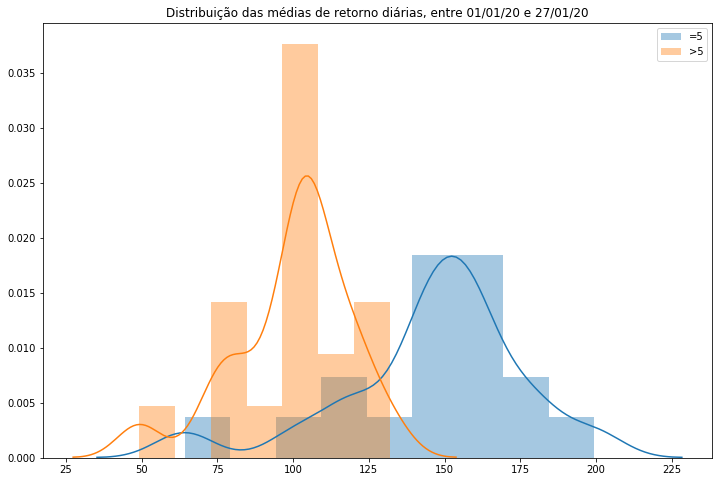

In [45]:
fig, ax = plt.subplots(figsize=(12,8))

sns.distplot(Mean5_size, label = '=5')
sns.distplot(Mean_b_5_size, label = '>5')


ax.set_title('Distribuição das médias de retorno diárias, entre 01/01/20 e 27/01/20')
# sns.distplot(C_, label = 'All')
ax.legend()

In [46]:
level_data = pr.get_parquet('DOLG20', '2020-01-10', "level-book")


In [47]:
level_data

{'bid_price': <pyarrow.parquet.ParquetFile at 0x7f24a1a70e80>,
 'bid_quantity': <pyarrow.parquet.ParquetFile at 0x7f24947aaba8>,
 'bid_broker': <pyarrow.parquet.ParquetFile at 0x7f24a1a469b0>,
 'bid_inc_code': <pyarrow.parquet.ParquetFile at 0x7f24a1a66c88>,
 'bid_order_id': <pyarrow.parquet.ParquetFile at 0x7f24a1a66cc0>,
 'bid_level_len': <pyarrow.parquet.ParquetFile at 0x7f248de91b38>,
 'ask_price': <pyarrow.parquet.ParquetFile at 0x7f2493fd51d0>,
 'ask_quantity': <pyarrow.parquet.ParquetFile at 0x7f2493fea828>,
 'ask_broker': <pyarrow.parquet.ParquetFile at 0x7f2493fc1e80>,
 'ask_inc_code': <pyarrow.parquet.ParquetFile at 0x7f2493fe9518>,
 'ask_order_id': <pyarrow.parquet.ParquetFile at 0x7f2493fe9550>,
 'ask_level_len': <pyarrow.parquet.ParquetFile at 0x7f2494b203c8>}

In [49]:
events = pr.get_parquet('DOLG20', '2020-01-10', "events")["incremental"].read().to_pandas()

In [50]:
events

,id,msg_seq_num,symbol,event_type,side,position,order_id,broker,order_ts,price,quantity,status,i
ts,,,,,,,,,,,,,
2020-01-10 10:30:08.551000+00:00,142690244,15750754,DOLG20,STARTED,None,NaN,NaN,NaN,None,NaN,NaN,None,0
2020-01-10 10:30:08.551000+00:00,142690513,15750754,DOLG20,STATUS,None,NaN,NaN,NaN,None,NaN,NaN,FORBIDDEN,1
2020-01-10 11:42:00.001000+00:00,142691821,15751816,DOLG20,STATUS,None,NaN,NaN,NaN,None,NaN,NaN,FORBIDDEN,2
2020-01-10 11:55:00.002000+00:00,142691952,15751842,DOLG20,STATUS,None,NaN,NaN,NaN,None,NaN,NaN,PRE_OPEN,3
2020-01-10 11:55:00.024000+00:00,142692228,15751862,DOLG20,STARTED,None,NaN,NaN,NaN,None,NaN,NaN,None,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-10 21:14:59.476000+00:00,146332508,19362352,DOLG20,INSERT,A,38.0,7.446147e+11,1618.0,21:14:59.475000,4106.0,5.0,None,704192
2020-01-10 21:14:59.774000+00:00,146332512,19362355,DOLG20,DELETE,A,28.0,7.446147e+11,122.0,21:14:59.773000,NaN,NaN,None,704193
2020-01-10 21:14:59.774000+00:00,146332513,19362355,DOLG20,INSERT,A,2.0,7.446147e+11,122.0,21:14:59.773000,4100.0,20.0,None,704194
